# Open quesions:
    * What to do with missing days (e.g. 2019-11-28 [Thanksgivbing])
    * Non-unique tickers/isins
    * L1 and L2 lengths - currently calendar days - should be trading days? - Might make BIG difference when aggregating

In [1]:
# Standard
import pandas as pd
import numpy as np
import pickle

# Time Cleaning
import time
import datetime
from dateutil.relativedelta import relativedelta

# Scraping
import requests
import locale
from pandas.io.json import json_normalize
import io

from os.path import exists

import statsmodels.api as sm
from statsmodels import regression


import matplotlib.pyplot as plt

# Import User Defined functions
import source.read_tickers_and_isins as URTI
import source.get_directors_dealings as UGDD
import source.get_timeseries as UGT
import source.analyze_get_summary_of_data as AGSOD
import source.preprocess_directors_dealings as UPDD
import source.preprocess_timeseries as UPTS
import source.preprocess_timeseries_from_excel as UPTFE
import source.analyse_single_company as UASC

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Read in single company to "analyze"

In [2]:
_isin = 'US02376R1023'
DATA_LOCATION = 'data/'
DATA_LOCATION_TIME_SERIES_PROCESSED = DATA_LOCATION + 'processed/timeseries/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI/'

_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

file_loc = _ri_location + _isin + '.pickle'
with open(file_loc, "rb") as f:
    type = pickle.load(f)
    isin = pickle.load(f)
    name = pickle.load(f)
    ticker = pickle.load(f)
    start_date = pickle.load(f)
    end_date = pickle.load(f)
    return_index_df = pickle.load(f)
#display(return_index_df)

company_return = return_index_df
display(company_return)

# Probably need a try/catch here
insider_data_df = pd.read_csv(_insider_location + ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
#display(insider_data_df)


,ReturnIndex
Date,
2016-03-21,179.65
2016-03-22,176.71
2016-03-23,173.24
2016-03-24,167.37
2016-03-25,167.37
...,...
2022-03-15,67.15
2022-03-16,71.03
2022-03-17,71.37


### Get market timeseries - used for "normal returns"

Move this to somewhere that makes sense

Perfect! seems to work

In [3]:
end_time = datetime.datetime(2022, 3, 21, 23, 59, 59)
_end_time_unix = int(time.mktime(end_time.timetuple()))
print(_end_time_unix)

start_time = datetime.datetime(2016, 3, 21, 0, 0, 0)
_start_time_unix = int(time.mktime(start_time.timetuple()))

print(_start_time_unix)
_ticker = '%5EIXIC'

url = f'https://query1.finance.yahoo.com/v7/finance/download/{_ticker}?period1={_start_time_unix}&period2={_end_time_unix}&interval=1d&events=history&includeAdjustedClose=true'

market_timeseries = pd.read_csv(url)
market_timeseries = market_timeseries.set_index('Date')
market_timeseries.index = market_timeseries.index.astype('datetime64[ns]')

market_timeseries

1647903599
1458514800


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-21,4787.310059,4814.850098,4785.379883,4808.870117,4808.870117,1609230000
2016-03-22,4783.600098,4835.600098,4781.709961,4821.660156,4821.660156,1596200000
2016-03-23,4813.870117,4816.669922,4765.370117,4768.859863,4768.859863,1732630000
2016-03-24,4743.359863,4773.500000,4734.770020,4773.500000,4773.500000,1590990000
2016-03-28,4785.250000,4787.390137,4760.009766,4766.790039,4766.790039,1381000000
...,...,...,...,...,...,...
2022-03-15,12685.230469,12973.879883,12616.589844,12948.620117,12948.620117,5414590000
2022-03-16,13119.370117,13440.120117,12992.200195,13436.549805,13436.549805,6498110000
2022-03-17,13360.719727,13620.799805,13317.139648,13614.780273,13614.780273,5575030000


# Define Events windows (PEF_8 page 34)

In [4]:
# This date will be moved to a loop
event_timestamp = insider_data_df['FilingDate'][0]
event_timestamp = event_timestamp.floor('d')
event_timestamp

# Change to trading days? currently calendar days
L1_length = 100
L2_length = 20

# Event-Window (L2):
T1 = event_timestamp - datetime.timedelta(days = L2_length)
T2 = event_timestamp + datetime.timedelta(days = L2_length)

# Estimation Window:
T0 = T1 - datetime.timedelta(days = L1_length + 1)

## Break T0 and T1 to cheat so we don't start with NAs
T1_ = T1 - datetime.timedelta(days = 1)
T0_ = T0 - datetime.timedelta(days = 1)

print(f'Estimation Window ({str(L1_length)} days): from {str(T0)} to {str(T1)}')
print(f'Event Window      ( {str(L2_length)} days): from {str(T1)} to {str(T0)}')

# Cut return timeseries into correct periods

## Estimation Window
### For estimating alphas and betas
estimation_window_index_market = (market_timeseries.index >= T0_) & (market_timeseries.index < T1)
estimation_window_index_company = (company_return.index >= T0_) & (company_return.index < T1)

estimation_window_market_timeseries = market_timeseries[estimation_window_index_market]
estimation_market_count = estimation_window_market_timeseries.shape[0]

estimation_window_company_timeseries = company_return[estimation_window_index_company]
estimation_company_count = estimation_window_company_timeseries.shape[0]

# Unify indexing, so that both contain same amount of trading days.
if (estimation_company_count > estimation_market_count):
    idx = estimation_window_company_timeseries.index
    estimation_window_market_timeseries = estimation_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_market_timeseries['Adj Close'] = estimation_window_market_timeseries['Adj Close'].fillna(method='ffill')
if (estimation_market_count > estimation_company_count):
    idx = estimation_window_market_timeseries.index
    estimation_window_company_timeseries = estimation_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_company_timeseries['ReturnIndex'] = estimation_window_company_timeseries['ReturnIndex'].fillna(method='ffill')

## Event-Window
event_window_index_market = (market_timeseries.index >= T1_) & (market_timeseries.index < T2)
event_window_index_company = (company_return.index >= T1_) & (company_return.index < T2)

event_window_market_timeseries = market_timeseries[event_window_index_market]
event_market_count = event_window_market_timeseries.shape[0]

event_window_company_timeseries = company_return[event_window_index_company]
event_company_count = event_window_company_timeseries.shape[0]

# Unify indexing, so that both contain same amount of trading days.
if (event_company_count > event_market_count):
    idx = event_window_company_timeseries.index
    event_window_market_timeseries = event_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_market_timeseries['Adj Close'] = event_window_market_timeseries['Adj Close'].fillna(method='ffill')
if (event_market_count > event_company_count):
    idx = event_window_market_timeseries.index
    event_window_company_timeseries = event_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_company_timeseries['ReturnIndex'] = event_window_company_timeseries['ReturnIndex'].fillna(method='ffill')

# Calculate percentage returns
estimation_window_market_return = estimation_window_market_timeseries['Adj Close'].pct_change()
estimation_window_company_return = estimation_window_company_timeseries['ReturnIndex'].pct_change()

event_window_market_return = event_window_market_timeseries['Adj Close'].pct_change()
event_window_company_return = event_window_company_timeseries['ReturnIndex'].pct_change()

## Remove the fake first date
estimation_window_market_return = estimation_window_market_return.iloc[1:]
estimation_window_company_return = estimation_window_company_return.iloc[1:]

event_window_market_return = event_window_market_return.iloc[1:]
event_window_company_return = event_window_company_return.iloc[1:]

print('shape after aggregating')
print(f'estimation_window_market_return: {estimation_window_market_return.shape}')
print(f'estimation_window_market_return: {estimation_window_market_return.shape}')
print(f'event_window_market_return: {event_window_market_return.shape}')
print(f'event_window_company_return: {event_window_company_return.shape}')

# Calculate coefficients

X = estimation_window_market_return.values
Y = estimation_window_company_return.values

def linreg(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    print(model.summary())
    
    # Remove the constant
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)

print(f'alpha: {str(alpha)}')
print(f'beta: {str(beta)}')

Estimation Window (100 days): from 2019-11-03 00:00:00 to 2020-02-12 00:00:00
Event Window      ( 20 days): from 2020-02-12 00:00:00 to 2019-11-03 00:00:00
shape after aggregating
estimation_window_market_return: (71,)
estimation_window_market_return: (71,)
event_window_market_return: (28,)
event_window_company_return: (28,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     54.24
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           2.89e-10
Time:                        15:28:39   Log-Likelihood:                 190.63
No. Observations:                  71   AIC:                            -377.3
Df Residuals:                      69   BIC:                            -372.7
Df Model:                           1    

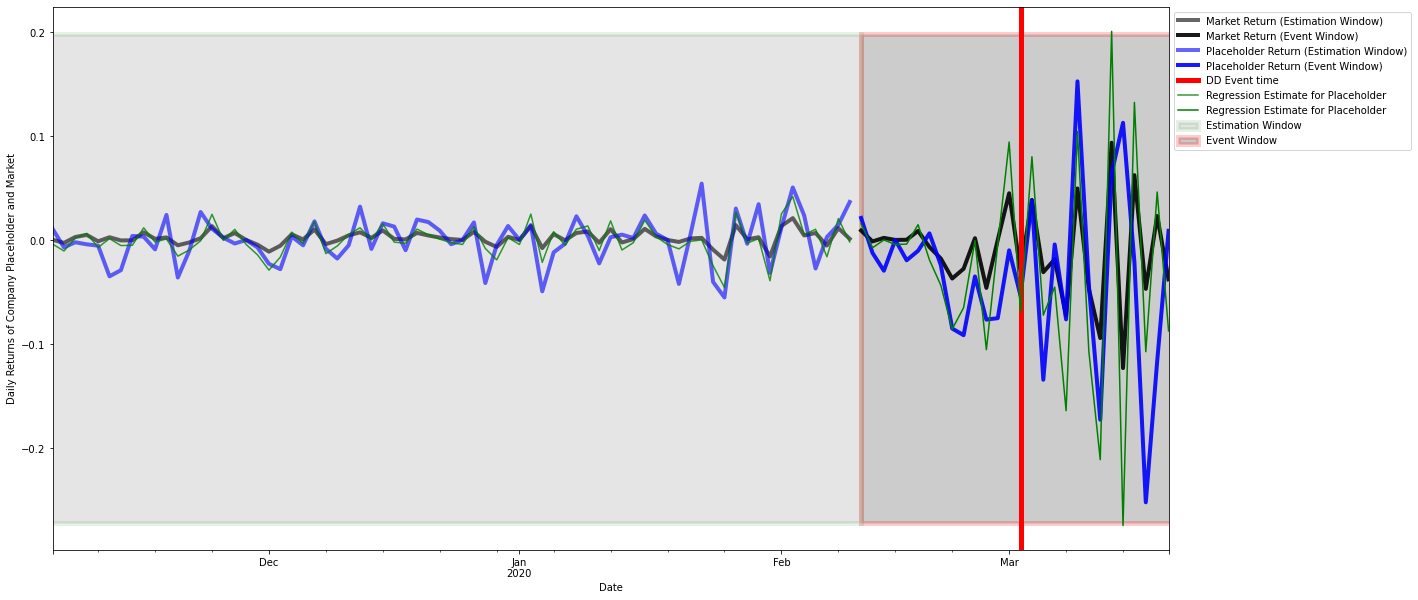

In [5]:
Company_name = 'Placeholder'

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha


plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)


plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()